In [356]:
import scipy.io as sio
from scipy.io import readsav
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee

In [2]:
s = readsav('hd212657/avhd212657ccfresids.idl')
txt_file = pd.read_csv("hd212657/HD212657.RV.txt",delimiter="\t")

bjd_list = s['jdb']
rv_list = s['vrad']*1000 #m/s
rv_error = np.array((txt_file['svrad']))
ccf_list = s['ccfresids']


# create pandas dataframe
df = pd.DataFrame(list(zip(bjd_list, rv_list, rv_error, ccf_list)), columns=["BJD","vrad", "svrad", "CCF"])
df_sorted = df.sort_values(by=['BJD'])   

# format data for LS fit
rv_np = np.array(list(df_sorted["vrad"]-np.mean(df_sorted["vrad"])))
ccf_list_np = np.array(list(df_sorted["CCF"]))
ccf_list_np_transpose = ccf_list_np.transpose()
time_np = np.array(df_sorted["BJD"])-np.min(df_sorted["BJD"])


In [3]:
#Period
period = 9.978570

# time of conjuction
T_c = 2456979.9326-2400000-np.min(df_sorted["BJD"])
T_c

-274.6605240000572

Text(0, 0.5, 'RV (m/s)')

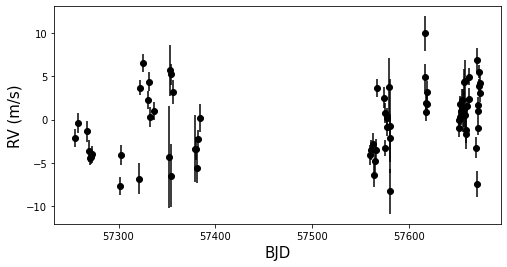

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

x = df_sorted["BJD"]
y = df_sorted["vrad"]-np.mean(df_sorted["vrad"])
yerr = df_sorted["svrad"]

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax.errorbar(x, y, yerr = yerr, fmt = 'o', color='k')
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)

In [294]:
#number of columns
ccf_indexes = [15, 31, 64 , 72 ,76 , 80 , 84,  88 ,92,  96, 145]
#[15, 31, 64  ,68 , 72 ,76 , 80 , 84,  88 ,92,  96, 120, 145] #another optimization point

n_cols =len(ccf_indexes)+4
n_rows = len(ccf_list_np) # len(ccf_list_np)<---- unsmoothed
x = np.zeros((n_rows, n_cols))

# delete this line later
period = 9.978570

x[:,0] =  1
x[:,1] =  time_np # remove for L-S
x[:,2] =  time_np**2 # remove for L-S
x[:,3] =  np.sin(2*np.pi*(time_np-T_c)/period+np.pi) #try a whole bunch periods
#x[:,4] =  np.cos(2*np.pi*(time_np-T_c)/period)


# add variables for every position in x per ccf. Each variable has all observations for that position in x
# if choosing random points within x evenly sampled
#for i in np.arange(0, 11):
#    X[:,i+5] = ccf_list_np_transpose[16*i] #(for all observations)

for i in np.arange(0, len(ccf_indexes)):
    x[:,i+4] = ccf_list_np_transpose[ccf_indexes[i]] #(for all observations)

#Using the smoothed over CCFs
#for i in np.arange(0, len(master_binned_center_CCFs_transpose)):
#    X[:,i+5] = master_binned_center_CCFs_transpose[i]

y = rv_np

In [307]:
alpha = x.transpose().dot(x)
beta = x.transpose().dot(y)

# and finally we can write a_coeff = alpha^-1 * beta
inv_alpha = np.linalg.inv(alpha)
a_coeff = inv_alpha.dot(beta)

In [308]:
a_coeff[3]

1.9852033754868526

In [309]:
CCF_matrix = np.zeros((n_rows, len(ccf_indexes)))
print(len(ccf_indexes))
for i in np.arange(0, len(ccf_indexes)):
    CCF_matrix[:,i] = ccf_list_np_transpose[ccf_indexes[i]] #(for all observations)

11


In [310]:
def log_likelihood(theta, t, x, y, e):
    amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10= theta
    model = amplitude * np.sin(2*np.pi*(t-T_c)/period + np.pi) + D + a0*x[:,0] + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4] +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] + a8*x[:,8]+ a9*x[:,9] + a10*x[:,10] #+ a11*x[:,11] +a12*x[:,12]
    sigma2 = e**2 + jitterpar**2
    loglikelihood =  -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    return loglikelihood

In [311]:
solnx = np.array([1.89571103e+00,  2.20048546e+00, -7.21531857e-09])
solnx
for i in np.arange(0, len(a_coeff[4:])):
    solnx = np.append(solnx, a_coeff[4:][i])

In [313]:
len(solnx)

14

In [314]:
len(ccf_indexes)

11

In [315]:
def log_prior(theta):
    amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = theta
    if -5 < amplitude < 10.0 and 0.01 < jitterpar < 4.0:
        return 0.0
    return -np.inf

In [316]:
def log_probability(theta, t, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, x, y, yerr)

In [317]:
pos = solnx + 1e-4 * np.random.randn(60, len(solnx)) #ball size array for each parameter
#pos[:,3] = pos[:,3]*2.6897657941202826e+14
#pos[:,13] = pos[:,13]*2.6897657941202826e+14
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_np, CCF_matrix, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [03:35<00:00, 23.19it/s]


State([[ 2.73570994e+00  2.17158457e+00  2.95826603e-01  3.08179772e+03
  -3.66341849e+03  1.63074774e+03 -4.35194167e+03 -2.37235915e+03
  -1.66738340e+03  1.07654750e+03  4.21012101e+03  8.87584514e+02
   1.12351011e+03 -3.32746604e+03]
 [ 2.35024340e+00  2.20695874e+00 -3.28136288e-01  2.87981003e+03
  -7.01703717e+03  3.26322466e+03 -1.33397786e+03 -1.95282858e+03
   3.44701637e+02 -1.60389824e+03  2.15690782e+03 -3.26595755e+03
   2.94269830e+03 -3.76144310e+03]
 [ 1.29563311e+00  1.68973620e+00 -1.14861568e-01 -7.04548882e+02
  -2.81011082e+03 -4.77330153e+02 -1.35686983e+02 -3.55284565e+03
   1.22689627e+03 -2.74137942e+03  5.63202125e+03 -3.02069627e+03
   1.87723398e+03 -3.43228227e+03]
 [ 1.45840280e+00  2.34767790e+00 -2.57008219e-01 -1.22690825e+03
  -2.10836455e+03 -5.76265193e+02 -2.29014688e+03 -3.49192026e+03
   3.00680203e+03 -2.09584474e+03 -2.37414960e+02  3.15898317e+03
   2.69148302e+03 -1.77492296e+03]
 [ 1.97970387e+00  1.87853110e+00 -1.12145879e+00  4.85131931e

Text(0.5, 0, 'step number')

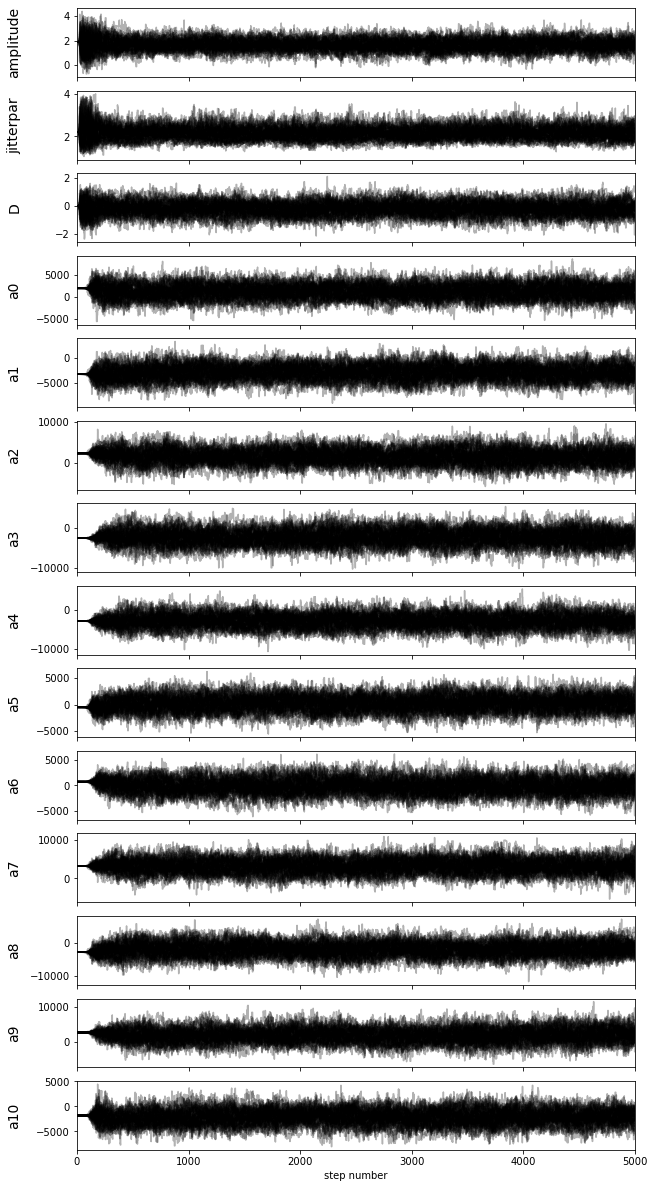

In [318]:
fig, axes = plt.subplots(len(solnx), figsize=(10, 1.5*len(solnx)), sharex=True)
samples = sampler.get_chain()
labels = ["amplitude", "jitterpar","D", "a0", "a1", "a2", "a3",
          "a4", "a5", "a6", "a7", "a8", "a9", "a10", "a11", "a12"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [321]:
# discard first 100 burn-in samples
flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
print(flat_samples.shape)

(12000, 14)


In [322]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

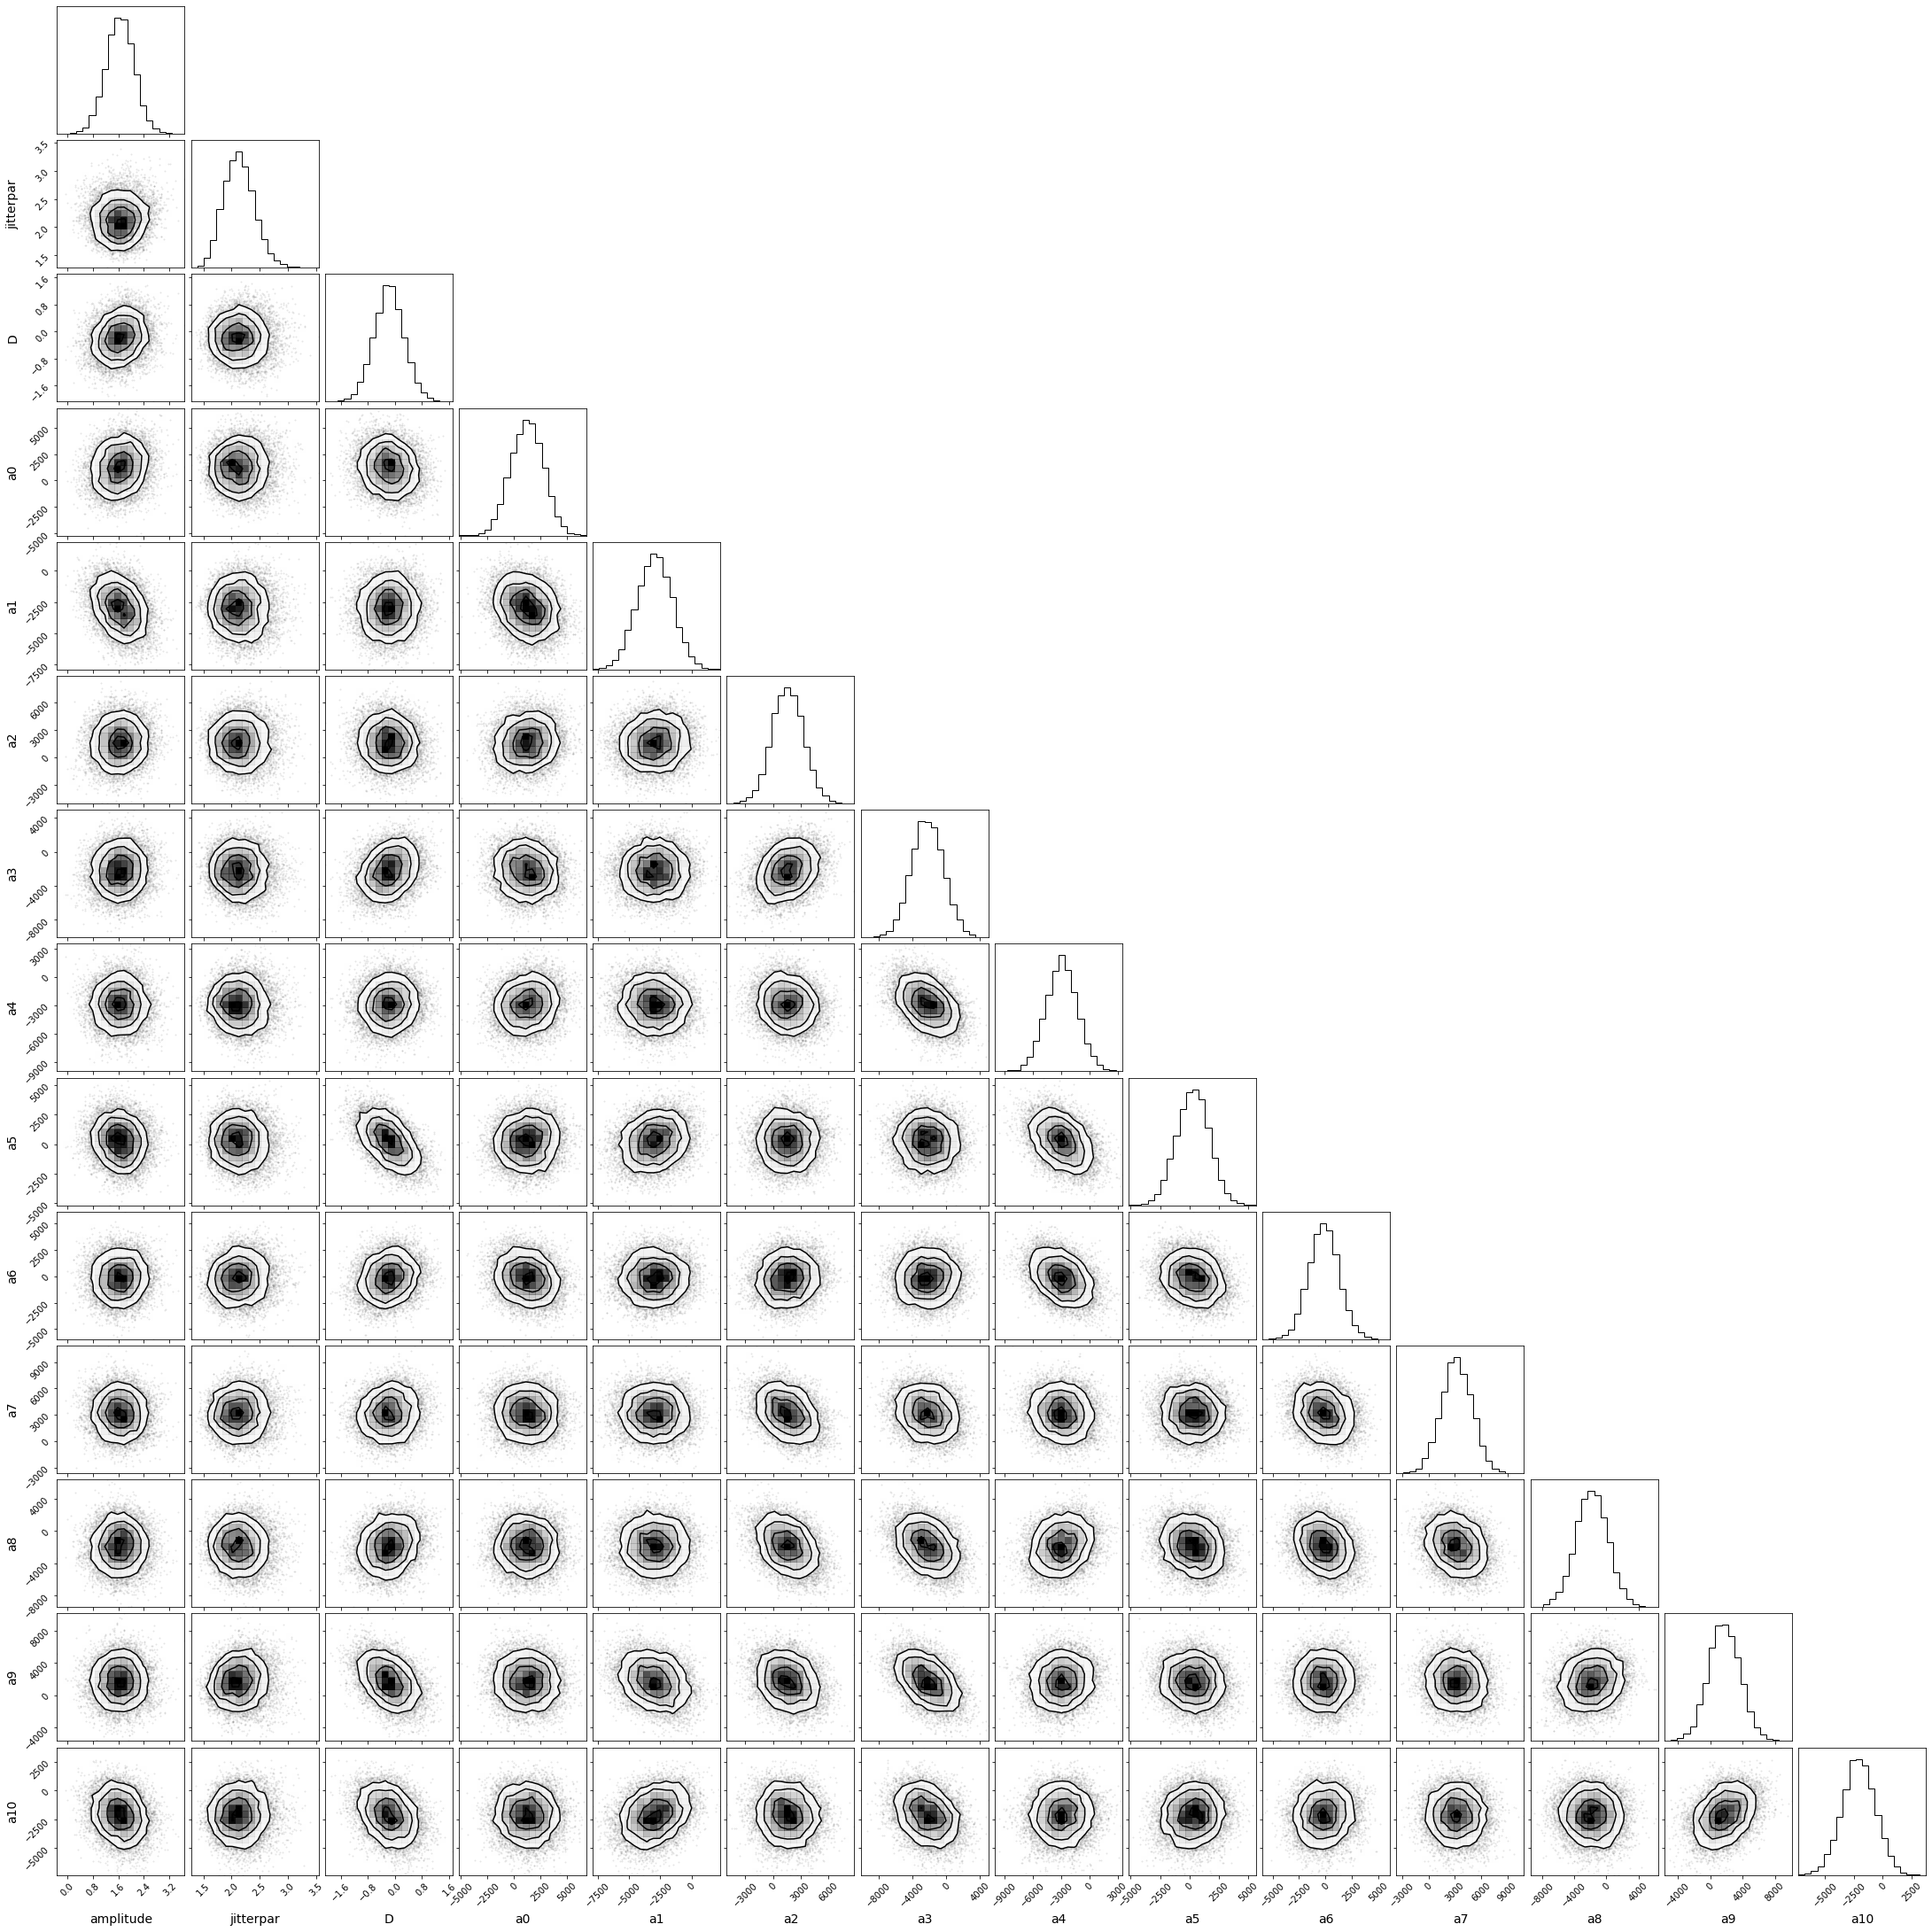

In [323]:
import corner
#fig, axes = plt.subplots(16, figsize=(25, 25), sharex=True)

fig = corner.corner(
    flat_samples, labels=labels, label_kwargs=dict(fontsize=14))
#fig.ylabels(size=16)
#, truths=[amplitude_true, jitterpar_true, D_true]
#);

In [342]:
amp_mcmc = np.percentile(flat_samples[:, 0], [50])[0]
jitterpar_mcmc = np.percentile(flat_samples[:, 1], [50])[0]
D_mcmc = np.percentile(flat_samples[:, 2], [50])[0]

A_mcmc_coeffs = np.zeros(11)
for i in np.arange(3, 14):
    A_mcmc_coeffs[i-3]=  np.percentile(flat_samples[:, i], [50])[0]

In [347]:
# phasefold data

planet = amp_mcmc * np.sin(2*np.pi*(time_np-T_c)/period + np.pi) + D_mcmc
activity_model = CCF_matrix.dot(A_mcmc_coeffs)
corrected_RVs = y-activity_model
uncorrected_RVs = y

phase = (time_np)%period
binned_RVs = [] 
binned_phases = []
binned_uncertainties = []
binned_uncorr_RVs = []

for i in range(0, 11):
    index= np.where(np.abs(phase-i+0.5) < 0.5)
    weighted_avg_rv = np.sum(corrected_RVs[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_uncorr_rv = np.sum(uncorrected_RVs[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_phases = np.sum(phase[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_uncertainty= np.sqrt(1.0/np.sum(1.0/rv_error[index]**2))
    binned_RVs.append(weighted_avg_rv)
    binned_uncorr_RVs.append(weighted_avg_uncorr_rv)
    binned_phases.append(weighted_avg_phases)
    binned_uncertainties.append(weighted_avg_uncertainty)


/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


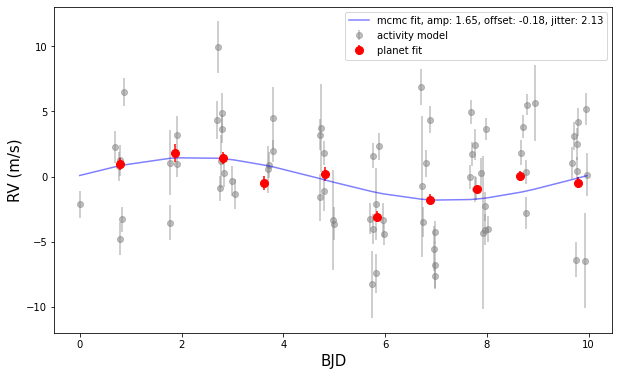

In [355]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

planet_mcmc = amp_mcmc * np.sin(2*np.pi*(time_np-T_c)/period + np.pi)+ D_mcmc

phase = (time_np)%period
df_rv_mcmc= pd.DataFrame(list(zip(phase,planet_mcmc)), 
               columns =['phases',"planet",]) 
df_rv_mcmc_sorted = df_rv_mcmc.sort_values(by=['phases'])


#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
#ax[0].errorbar(X, Y, yerr = yerr, fmt = 'o', color='k', label="Corrected RVs")
#ax[0].errorbar(X, amp_ml * np.sin(2*np.pi*(X-T_c)/period + np.pi)+ D_ml , yerr = jitterpar_ml, fmt = 'o', color='b', label="ML")
#ax[0].set_xlabel("BJD", size=15)
#ax[0].set_ylabel("RV (m/s)",size=15)
#ax[0].legend()

ax.errorbar(phase, y, yerr = yerr, fmt = 'o', color='grey', alpha=0.5, label="activity model", zorder=1)
#plt.errorbar(binned_phases, binned_uncorr_RVs, yerr = binned_uncertainties, fmt = 'o', color='b', alpha=1, markersize = 8, label="planet fit", zorder=1)
ax.errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, fmt = 'o', color='r', alpha=1, markersize = 8, label="planet fit", zorder=2)
ax.plot(df_rv_mcmc_sorted["phases"], df_rv_mcmc_sorted["planet"], color='b',zorder=2, alpha=0.5, 
        label="mcmc fit, amp: "+str(round(amp_mcmc,2))+", offset: "+str(round(D_mcmc,2))+", jitter: "+str(round(jitterpar_mcmc, 2)))
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)
ax.legend()

## Old code below (12/21/2020)

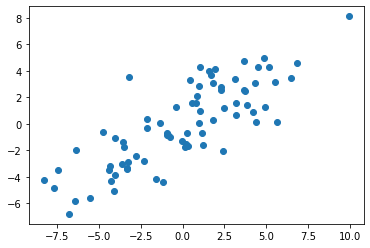

In [14]:
plt.scatter(y, x.dot(a_coeff))

418.9149000000034


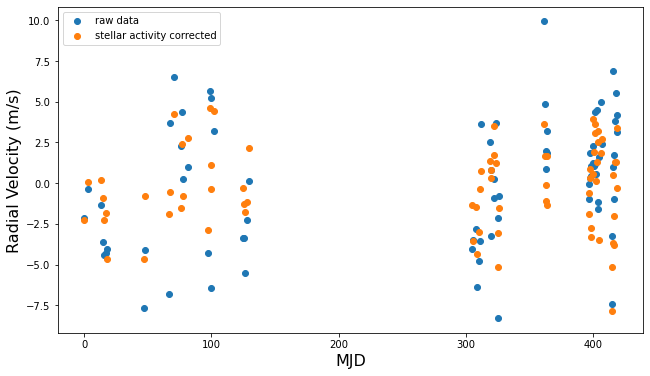

In [16]:
planet = a_coeff[3]*np.sin(2*np.pi*(time_np-T_c)/period+np.pi)
activity_model = x.dot(a_coeff)-planet
corrected_RVs = y-activity_model

fig, ax1 = plt.subplots(1, 1, figsize=(10.5, 6))

plt.scatter(time_np, y, label="raw data")
plt.scatter(time_np, corrected_RVs, label="stellar activity corrected")


plt.legend(loc="upper left")
plt.xlabel("MJD", size=16)
plt.ylabel("Radial Velocity (m/s)", size=16)
print(np.max(time_np))

/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


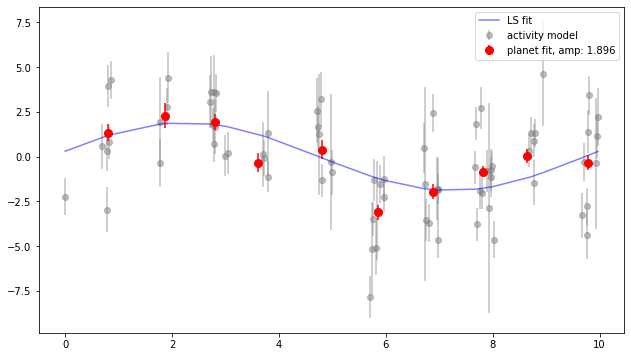

In [18]:
phase = (time_np)%period
df_rv= pd.DataFrame(list(zip(phase,planet)), 
               columns =['phases',"planet",]) 
df_rv_sorted = df_rv.sort_values(by=['phases'])

uncorrected_RVs = y
phase = (time_np)%period
binned_RVs = [] 
binned_phases = []
binned_uncertainties = []
binned_uncorr_RVs = []

for i in range(0, 11):
    index= np.where(np.abs(phase-i+0.5) < 0.5)
    weighted_avg_rv = np.sum(corrected_RVs[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_uncorr_rv = np.sum(uncorrected_RVs[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_phases = np.sum(phase[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_uncertainty= np.sqrt(1.0/np.sum(1.0/rv_error[index]**2))
    binned_RVs.append(weighted_avg_rv)
    binned_uncorr_RVs.append(weighted_avg_uncorr_rv)
    binned_phases.append(weighted_avg_phases)
    binned_uncertainties.append(weighted_avg_uncertainty)

fig, ax1 = plt.subplots(1, 1, figsize=(10.5, 6))


plt.errorbar(phase, y-activity_model, yerr = yerr, fmt = 'o', color='grey', alpha=0.5, label="activity model", zorder=1)
#plt.errorbar(binned_phases, binned_uncorr_RVs, yerr = binned_uncertainties, fmt = 'o', color='b', alpha=1, markersize = 8, label="planet fit", zorder=1)
plt.errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, fmt = 'o', color='r', alpha=1, markersize = 8, label="planet fit, amp: "+str(round(a_coeff[3],3)), zorder=2)
plt.plot(df_rv_sorted["phases"], df_rv_sorted["planet"], color='b',zorder=2, alpha=0.5, label="LS fit")
plt.legend()

In [19]:
len(a_coeff)

17

In [20]:
Y = corrected_RVs
X = time_np

In [21]:
X

array([  0.      ,   2.985871,  13.026671,  14.967231,  15.950859,
        16.954231,  17.992982,  46.885285,  47.885751,  66.853903,
        67.859406,  70.711653,  75.739282,  76.73964 ,  77.737891,
        81.740275,  97.729564,  98.743873,  99.741459,  99.762302,
       101.703232, 124.710576, 125.70851 , 126.706549, 127.70519 ,
       129.707777, 305.125443, 306.10709 , 308.118672, 309.111058,
       310.125123, 311.114533, 312.125239, 319.11168 , 320.089239,
       320.142854, 322.074601, 322.141515, 324.061358, 325.056367,
       325.138641, 326.039464, 361.948987, 362.024069, 362.957032,
       363.028086, 363.954623, 364.027112, 396.835571, 396.931527,
       397.834682, 397.93286 , 398.8393  , 398.935626, 399.83916 ,
       399.937546, 400.916561, 401.842568, 401.920758, 402.837817,
       402.93478 , 403.859696, 403.934969, 404.906259, 406.825363,
       406.915635, 414.832817, 414.936132, 415.833281, 415.918494,
       416.826058, 416.913112, 417.829828, 417.915528, 418.823

In [44]:
# a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, log_f = theta
# model = a0 + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4] +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] + a8*x[:,8]+ a9*x[:,9] + a10*x[:,10] + a11*x[:,11] + a12*x[:,12] +a13*x[:,13] + a13*x[:,13] + a14*x[:,14] + a15*x[:,15]  #m * x + b

In [22]:
def log_likelihood(theta, x, y, yerr):
    amplitude, jitterpar, D = theta
    model = amplitude * np.sin(2*np.pi*(x-T_c)/period + np.pi)+ D 
    sigma2 = e**2 + jitterpar**2
    loglikelihood =  -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    
    
    return loglikelihood
    #sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    #return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [23]:
from scipy.optimize import minimize

amplitude_true = 1.5
#B_true = 2*np.pi/period
#C_true = 0.0
jitterpar_true = 1.8
D_true = 0.0
e = 0.451640314

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([amplitude_true, jitterpar_true, D_true]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(X, Y, yerr))
amp_ml, jitterpar_ml, D_ml = soln.x

print("Maximum likelihood estimates:")
print("amplitude = {0:.3f}".format(amp_ml))
#print("B = {0:.3f}".format(B_ml))
#print("C = {0:.3f}".format(C_ml))
print("jitterpar = {0:.3f}".format(jitterpar_ml))
print("D = {0:.3f}".format(D_ml))
#print("beta = {0:.3f}".format(beta_ml))
#print("gamma = {0:.3f}".format(gamma_ml))

#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
#plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
#plt.legend(fontsize=14)
#plt.xlim(0, 10)
#plt.xlabel("x")
#plt.ylabel("y");

Maximum likelihood estimates:
amplitude = 1.896
jitterpar = 2.200
D = -0.000


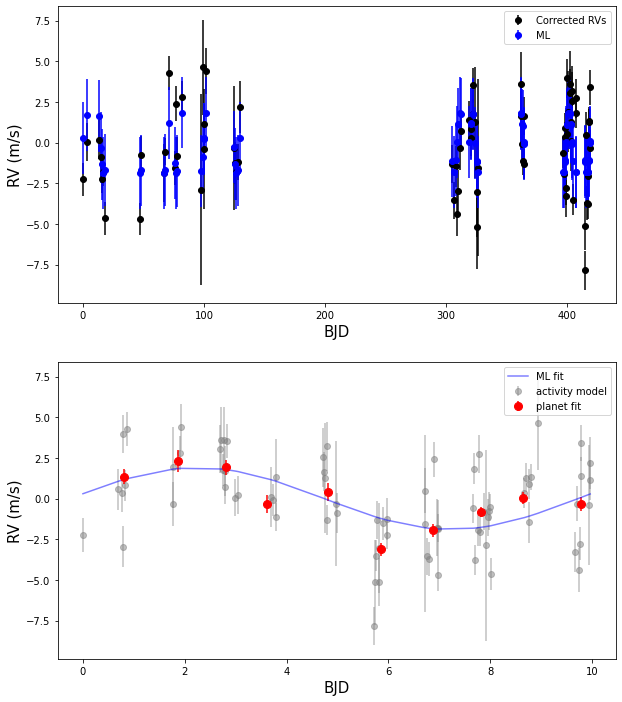

In [27]:
fig, ax = plt.subplots(2,1, figsize=(10, 12))

planet_ml = amp_ml * np.sin(2*np.pi*(time_np-T_c)/period + np.pi)+ D_ml

phase = (time_np)%period
df_rv_ml= pd.DataFrame(list(zip(phase,planet_ml)), 
               columns =['phases',"planet",]) 
df_rv_ml_sorted = df_rv.sort_values(by=['phases'])

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax[0].errorbar(X, Y, yerr = yerr, fmt = 'o', color='k', label="Corrected RVs")
ax[0].errorbar(X, amp_ml * np.sin(2*np.pi*(X-T_c)/period + np.pi)+ D_ml , yerr = jitterpar_ml, fmt = 'o', color='b', label="ML")
ax[0].set_xlabel("BJD", size=15)
ax[0].set_ylabel("RV (m/s)",size=15)
ax[0].legend()

ax[1].errorbar(phase, Y, yerr = yerr, fmt = 'o', color='grey', alpha=0.5, label="activity model", zorder=1)
#plt.errorbar(binned_phases, binned_uncorr_RVs, yerr = binned_uncertainties, fmt = 'o', color='b', alpha=1, markersize = 8, label="planet fit", zorder=1)
ax[1].errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, fmt = 'o', color='r', alpha=1, markersize = 8, label="planet fit", zorder=2)
ax[1].plot(df_rv_ml_sorted["phases"], df_rv_ml_sorted["planet"], color='b',zorder=2, alpha=0.5, label="ML fit")
ax[1].set_xlabel("BJD", size=15)
ax[1].set_ylabel("RV (m/s)",size=15)
ax[1].legend()

## Marginalization & uncertainty estimation

In [28]:
def log_prior(theta):
    amplitude, jitterpar, D = theta
    if -5 < amplitude < 10.0 and 0.01 < jitterpar < 4.0 and -5 < D < 5:
        return 0.0
    return -np.inf

In [29]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [30]:
pos = soln.x + 1e-4 * np.random.randn(32, 3) #ball size array for each parameter
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(X, Y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:09<00:00, 530.53it/s]


State([[ 2.41701198  2.25374855  0.08561173]
 [ 2.33040938  1.84945952 -0.05024736]
 [ 1.9796221   2.24818213 -0.27877096]
 [ 1.93920349  2.28890579  0.40535503]
 [ 2.02464181  2.34122195  0.27145289]
 [ 1.73416989  2.44705092 -0.22910907]
 [ 2.35755976  2.51312726 -0.1441166 ]
 [ 1.75479362  2.75716776 -0.13285423]
 [ 1.77615549  1.95664727 -0.00574154]
 [ 2.26293848  2.44343794  0.0398043 ]
 [ 1.26782493  2.08825999 -0.00305119]
 [ 1.61027728  2.02580456 -0.45372714]
 [ 1.64874864  2.42086729 -0.16346132]
 [ 1.9374117   2.06687039 -0.35516677]
 [ 1.93014929  2.00452401 -0.10180091]
 [ 1.77551465  2.0399304   0.13784256]
 [ 1.63401596  2.16589352 -0.30808144]
 [ 2.1753165   2.14844315 -0.03242154]
 [ 2.85394078  2.48200328 -0.04628319]
 [ 1.27975925  2.31516403 -0.13743428]
 [ 1.7118658   2.27813929 -0.26508922]
 [ 1.4884176   2.44281872 -0.01095121]
 [ 1.21797056  1.96860843  0.14959704]
 [ 2.0098817   2.75072887  0.21218214]
 [ 2.37752756  2.38159871 -0.01820699]
 [ 2.05146003  2.26

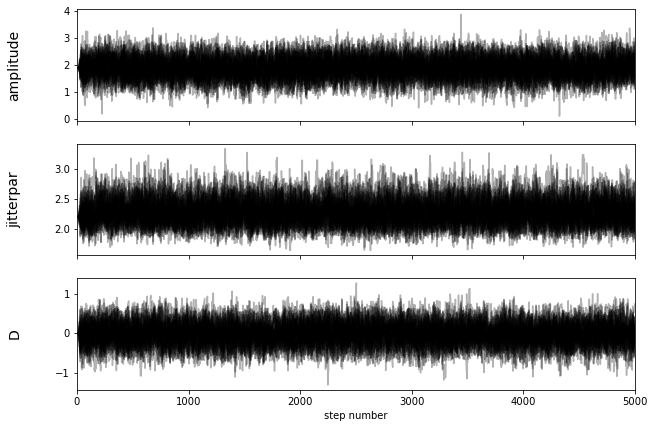

In [31]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["amplitude", "jitterpar", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [32]:
tau = sampler.get_autocorr_time()
print(tau)

[39.57296105 38.03463619 41.52791764]


In [33]:
# discard first 100 burn-in samples
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


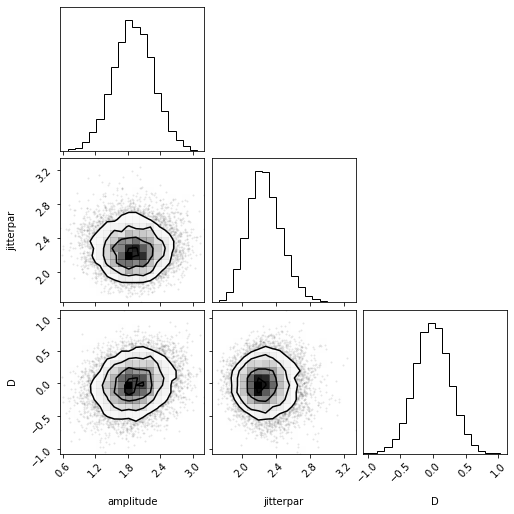

In [34]:
import corner

fig = corner.corner(
    flat_samples, labels=labels)#, truths=[amplitude_true, jitterpar_true, D_true]
#);

In [35]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [36]:
amp_mcmc = np.percentile(flat_samples[:, 0], [50])[0]
jitterpar_mcmc = np.percentile(flat_samples[:, 1], [50])[0]
D_mcmc = np.percentile(flat_samples[:, 2], [50])[0]

In [37]:
amp_mcmc

1.8990989354009011

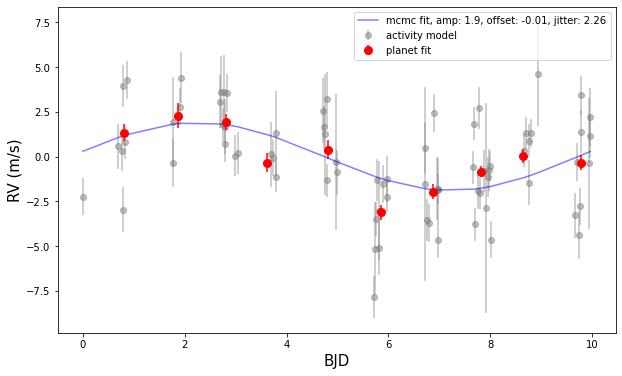

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

planet_mcmc = amp_mcmc * np.sin(2*np.pi*(x-T_c)/period + np.pi)+ D_mcmc

phase = (time_np)%period
df_rv_mcmc= pd.DataFrame(list(zip(phase,planet_mcmc)), 
               columns =['phases',"planet",]) 
df_rv_mcmc_sorted = df_rv.sort_values(by=['phases'])

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
#ax[0].errorbar(X, Y, yerr = yerr, fmt = 'o', color='k', label="Corrected RVs")
#ax[0].errorbar(X, amp_ml * np.sin(2*np.pi*(X-T_c)/period + np.pi)+ D_ml , yerr = jitterpar_ml, fmt = 'o', color='b', label="ML")
#ax[0].set_xlabel("BJD", size=15)
#ax[0].set_ylabel("RV (m/s)",size=15)
#ax[0].legend()

ax.errorbar(phase, Y, yerr = yerr, fmt = 'o', color='grey', alpha=0.5, label="activity model", zorder=1)
#plt.errorbar(binned_phases, binned_uncorr_RVs, yerr = binned_uncertainties, fmt = 'o', color='b', alpha=1, markersize = 8, label="planet fit", zorder=1)
ax.errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, fmt = 'o', color='r', alpha=1, markersize = 8, label="planet fit", zorder=2)
ax.plot(df_rv_mcmc_sorted["phases"], df_rv_mcmc_sorted["planet"], color='b',zorder=2, alpha=0.5, 
        label="mcmc fit, amp: "+str(round(amp_mcmc,2))+", offset: "+str(round(D_mcmc,2))+", jitter: "+str(round(jitterpar_mcmc, 2)))
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)
ax.legend()

## OG code below

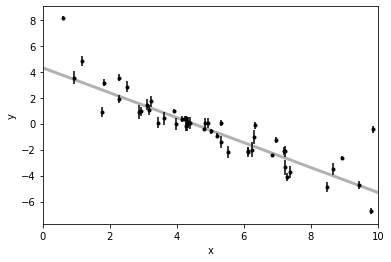

In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


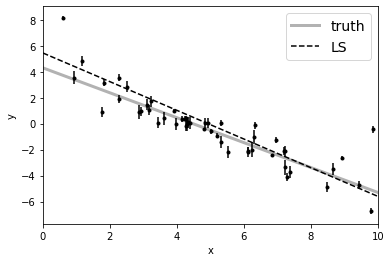

In [29]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## Maximum Likelihood Estimation

In [4]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


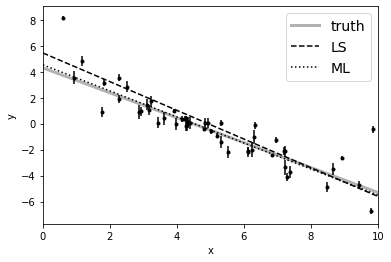

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## Marginalization & uncertainty estimation

In [6]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [7]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [10]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:07<00:00, 711.07it/s]


State([[-0.88571848  3.95740876 -0.50540213]
 [-0.9037139   4.13431481 -0.80470882]
 [-1.08069013  4.98628528 -0.91239079]
 [-1.06222588  4.77580239 -0.8907475 ]
 [-0.99343356  4.48258295 -0.89091486]
 [-0.93466916  4.17088183 -0.77864309]
 [-1.05808575  4.87948984 -0.94613664]
 [-0.92724825  4.17843572 -0.9183769 ]
 [-0.91279691  4.16970657 -0.76628316]
 [-1.12961147  5.08044704 -0.78035558]
 [-1.1922565   5.38875737 -0.92307747]
 [-1.07538085  4.96295956 -0.77902889]
 [-1.01349616  4.56962595 -0.77069875]
 [-1.01923275  4.62677678 -0.61840349]
 [-0.95259424  4.2960795  -0.71487166]
 [-1.01908761  4.56338609 -0.91284513]
 [-0.97027519  4.44386577 -0.53724676]
 [-1.09463631  4.86237864 -0.6865073 ]
 [-1.17946122  5.36909913 -0.99798149]
 [-0.97053285  4.33298227 -0.8096156 ]
 [-0.94486182  4.19638017 -0.63239056]
 [-0.99713532  4.44059124 -0.71055864]
 [-0.84455944  3.81362445 -0.53933767]
 [-0.91475479  4.09500536 -0.69099648]
 [-1.04132123  4.72112854 -0.6673316 ]
 [-1.04288268  4.72

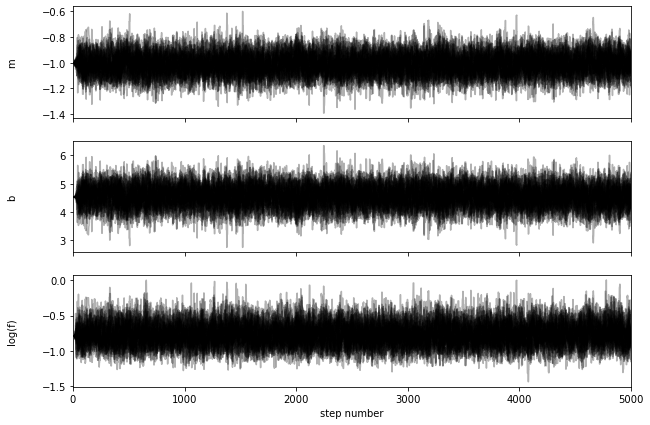

In [11]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[35.73919335 35.69339914 36.05722561]


In [13]:
# discard first 100 burn-in samples
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


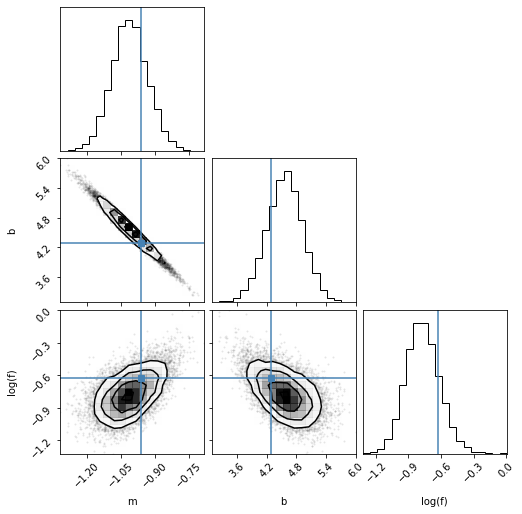

In [14]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

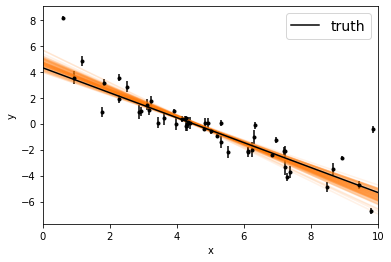

In [15]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [16]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>